# Modelling -Part -2

The weekly sales is being precited using features in dataset.(Not using time series approach)

In [1]:
#importing required packages
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
import seaborn as sns
sns.set_style("whitegrid")
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from datetime import datetime as dt
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn import linear_model
from sklearn.feature_selection import RFE
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import xgboost as xgb 

In [2]:
#reading data
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
store=pd.read_csv('stores.csv')
feature=pd.read_csv('features.csv')

In [3]:
#Merging train and features dataset
merge_df=pd.merge(train,feature, on=['Store','Date'], how='inner')

In [4]:
#Changing date as index
merge_df['DateTimeObj']=[dt.strptime(x,'%Y-%m-%d') for x in list(merge_df['Date'])]
merge_df['DateTimeObj'].head()

0   2010-02-05
1   2010-02-05
2   2010-02-05
3   2010-02-05
4   2010-02-05
Name: DateTimeObj, dtype: datetime64[ns]

In [5]:
merge_df.head(3)

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,DateTimeObj
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,2010-02-05
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,2010-02-05
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,2010-02-05


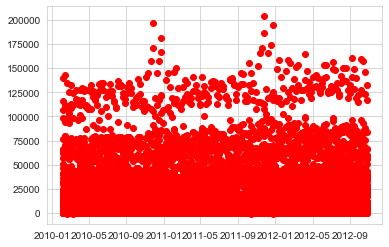

In [6]:
#Plotting  weekly sales of store 1 versus date 
plt.plot(merge_df[(merge_df.Store==1)].DateTimeObj, merge_df[(merge_df.Store==1)].Weekly_Sales, 'ro')
plt.show()

In [7]:
#Plotting weekly sales storewise
weeklysales=merge_df.groupby(['Store','Date'])['Weekly_Sales'].apply(lambda x:np.sum(x))
weeklysales[0:4]

Store  Date      
1      2010-02-05    1643690.90
       2010-02-12    1641957.44
       2010-02-19    1611968.17
       2010-02-26    1409727.59
Name: Weekly_Sales, dtype: float64

In [8]:
#Plotting weekly sales departmentwise
weeklysaledept=merge_df.groupby(['Store','Dept'])['Weekly_Sales'].apply(lambda x:np.sum(x))
weeklysaledept[0:5]

Store  Dept
1      1       3219405.18
       2       6592598.93
       3       1880518.36
       4       5285874.09
       5       3468885.58
Name: Weekly_Sales, dtype: float64

In [9]:
#Our approach is storewise,so taking that dataframe and resetting index
weeklyscale=weeklysales.reset_index()
weeklyscale[0:5]

,Store,Date,Weekly_Sales
0,1,2010-02-05,1643690.90
1,1,2010-02-12,1641957.44
2,1,2010-02-19,1611968.17
3,1,2010-02-26,1409727.59
4,1,2010-03-05,1554806.68


In [10]:
#Merging feature and weekly salers storewise
walmartstore=pd.merge(weeklyscale, feature, on=['Store', 'Date'], how='inner')
walmartstore.head()

,Store,Date,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,1643690.90,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,1641957.44,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,1611968.17,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,1409727.59,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,1554806.68,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [11]:
#Removing markdowns offer
walmartstoredf = walmartstore.iloc[:, list(range(5)) + list(range(10,13))]

In [12]:
#Resetting index
walmartstoredf['DateTimeObj'] = [dt.strptime(x, '%Y-%m-%d') for x in list(walmartstoredf['Date'])]
weekNo=walmartstoredf.reset_index()

In [13]:
#Adding an additional colum specifying week number
weekNo = [(x - walmartstoredf['DateTimeObj'][0]) for x in list(walmartstoredf['DateTimeObj'])]

In [14]:
walmartstoredf['Week'] = [np.timedelta64(x, 'D').astype(int)/7 for x in weekNo]

In [15]:
walmartstoredf.head()

,Store,Date,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,DateTimeObj,Week
0,1,2010-02-05,1643690.90,42.31,2.572,211.096358,8.106,False,2010-02-05,0.0
1,1,2010-02-12,1641957.44,38.51,2.548,211.242170,8.106,True,2010-02-12,1.0
2,1,2010-02-19,1611968.17,39.93,2.514,211.289143,8.106,False,2010-02-19,2.0
3,1,2010-02-26,1409727.59,46.63,2.561,211.319643,8.106,False,2010-02-26,3.0
4,1,2010-03-05,1554806.68,46.50,2.625,211.350143,8.106,False,2010-03-05,4.0


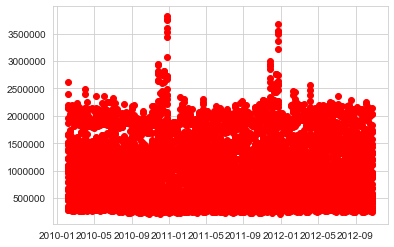

In [16]:
plt.plot(walmartstoredf.DateTimeObj, walmartstoredf.Weekly_Sales, 'ro')
plt.show()

In [17]:
#Integer value for is_holiday 
walmartstoredf['IsHolidayInt'] = [int(x) for x in list(walmartstoredf.IsHoliday)]
walmartstoredf.head(6)

,Store,Date,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,DateTimeObj,Week,IsHolidayInt
0,1,2010-02-05,1643690.90,42.31,2.572,211.096358,8.106,False,2010-02-05,0.0,0
1,1,2010-02-12,1641957.44,38.51,2.548,211.242170,8.106,True,2010-02-12,1.0,1
2,1,2010-02-19,1611968.17,39.93,2.514,211.289143,8.106,False,2010-02-19,2.0,0
3,1,2010-02-26,1409727.59,46.63,2.561,211.319643,8.106,False,2010-02-26,3.0,0
4,1,2010-03-05,1554806.68,46.50,2.625,211.350143,8.106,False,2010-03-05,4.0,0
5,1,2010-03-12,1439541.59,57.79,2.667,211.380643,8.106,False,2010-03-12,5.0,0


In [18]:
#train test split
train_WM, test_WM = train_test_split(walmartstoredf, test_size=0.3,random_state=42)

In [19]:
XTrain = train_WM[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Week', 'IsHolidayInt']]
YTrain = train_WM['Weekly_Sales']

In [20]:
XTest = test_WM[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Week', 'IsHolidayInt']]
YTest = test_WM['Weekly_Sales']

In [21]:
#Instantiate
wmLinear = linear_model.LinearRegression(normalize=True)
#Fit
wmLinear.fit(XTrain, YTrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [22]:
#Performance/Predict on the test data sets
YHatTest = wmLinear.predict(XTest)

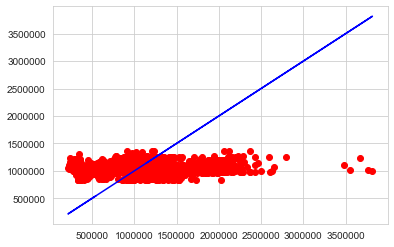

In [23]:
#Plot Predicted and actual values for test and train
plt.plot(YTest, YHatTest,'ro')
plt.plot(YTest, YTest,'b-')
plt.show()

In [24]:
# calculate the accuray of the model by sum of Square and mean absolute prediction error
MAPE = np.mean(abs((YTest - YHatTest)/YTest))
MSSE = np.mean(np.square(YHatTest - YTest))
print(r2_score(YTest,YHatTest))
print(MAPE, MSSE)


0.018399963104079542
0.6647628870821394 313837794216.65875


The accuracy is very low using only numerical columns.Lets use entire dataset for modelling.

In [25]:
#Get dummies
Store_Dummies = pd.get_dummies(walmartstoredf.Store, prefix='Store').iloc[:,1:]
walmartstoredf = pd.concat([walmartstoredf, Store_Dummies], axis=1)

In [26]:
walmartstoredf.head(6)

,Store,Date,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,DateTimeObj,Week,...,Store_36,Store_37,Store_38,Store_39,Store_40,Store_41,Store_42,Store_43,Store_44,Store_45
0,1,2010-02-05,1643690.90,42.31,2.572,211.096358,8.106,False,2010-02-05,0.0,...,0,0,0,0,0,0,0,0,0,0
1,1,2010-02-12,1641957.44,38.51,2.548,211.242170,8.106,True,2010-02-12,1.0,...,0,0,0,0,0,0,0,0,0,0
2,1,2010-02-19,1611968.17,39.93,2.514,211.289143,8.106,False,2010-02-19,2.0,...,0,0,0,0,0,0,0,0,0,0
3,1,2010-02-26,1409727.59,46.63,2.561,211.319643,8.106,False,2010-02-26,3.0,...,0,0,0,0,0,0,0,0,0,0
4,1,2010-03-05,1554806.68,46.50,2.625,211.350143,8.106,False,2010-03-05,4.0,...,0,0,0,0,0,0,0,0,0,0
5,1,2010-03-12,1439541.59,57.79,2.667,211.380643,8.106,False,2010-03-12,5.0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
#Train test split
train_WM, test_WM = train_test_split(walmartstoredf, test_size=0.3,random_state=42)
XTrain = train_WM.iloc[:,([3,4,5,6] + [9,10]) + list(range(11,walmartstoredf.shape[1]))]
yTrain = train_WM.Weekly_Sales
                                                    
XTest = test_WM.iloc[:,([3,4,5,6] + [9,10]) + list(range(11,walmartstoredf.shape[1]))]
yTest=test_WM.Weekly_Sales

In [28]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
scaler.fit(XTrain)
X_transformed_train= scaler.transform(XTrain)
X_transformed_test= scaler.transform(XTest)

#### 1.Linear Regression

In [29]:
#Instantiate 
wmLinear = linear_model.LinearRegression(normalize=True)
#fit
wmLinear.fit(XTrain, YTrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

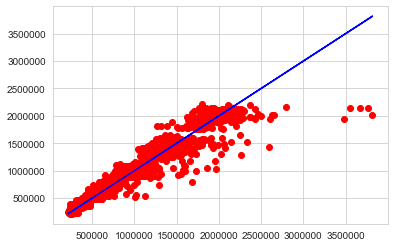

In [30]:
#Performance on the test data sets
YHatTest = wmLinear.predict(XTest)
plt.plot(YTest, YHatTest,'ro')
plt.plot(YTest, YTest,'b-')
plt.show()

In [31]:
# calculate the accuracy of the model by sum of Square and mean absolute prediction error
MAPE = np.mean(abs((YTest - YHatTest)/YTest))
MSSE = np.mean(np.square(YHatTest - YTest))
print(r2_score(YTest,YHatTest))
print(MAPE, MSSE)
print(MAPE, MSSE)

0.9164906274809529
0.08956881121002612 26699670214.63539
0.08956881121002612 26699670214.63539


Using scaled data:

0.9164906274809529
0.08956881121002612 26699670214.63539
0.08956881121002612 26699670214.63539


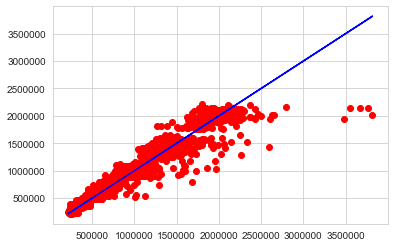

In [32]:
#Instantiate 
wmLinear = linear_model.LinearRegression(normalize=True)
#fir
wmLinear.fit(X_transformed_train, YTrain)
#Performance on the test data sets
YHatTest = wmLinear.predict(X_transformed_test)

# calculate the accuracy of the model by sum of Square and mean absolute prediction error
MAPE = np.mean(abs((YTest - YHatTest)/YTest))
MSSE = np.mean(np.square(YHatTest - YTest))
print(r2_score(YTest,YHatTest))
print(MAPE, MSSE)
print(MAPE, MSSE)
plt.plot(YTest, YHatTest,'ro')
plt.plot(YTest, YTest,'b-')
plt.show()

C:\Users\b16z\Anaconda3\envs\deeplearning\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56023494849469.734, tolerance: 143142991402.9765
  positive)
C:\Users\b16z\Anaconda3\envs\deeplearning\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55365629274480.0, tolerance: 143142991402.9765
  positive)
C:\Users\b16z\Anaconda3\envs\deeplearning\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 53671765333390.85, tolerance: 143142991402.9765
  positive)
C:\Users\b16z\Anaconda3\envs\deeplearning\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge

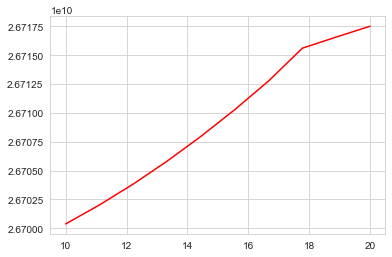

In [33]:
alphas = np.linspace(10, 20, 10)
#Hyper parameter optimisation
testError = np.empty(10)

for i, alpha in enumerate(alphas) :
    
    lasso = Lasso(alpha=alpha)
    lasso.fit(XTrain, YTrain)
    testError[i] = mean_squared_error(YTest, lasso.predict(XTest))
plt.plot(alphas, testError, 'r-')
plt.show()

17 seems to be ideal value for hyperparameter.

In [34]:
lasso = Lasso(alpha=17)
lasso.fit(XTrain, YTrain)

C:\Users\b16z\Anaconda3\envs\deeplearning\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55237662443319.19, tolerance: 143142991402.9765
  positive)


Lasso(alpha=17, copy_X=True, fit_intercept=True, max_iter=1000, normalize=False,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False)

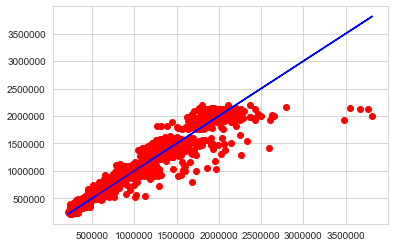

In [35]:
#Performance on the test data sets
YHatTest =lasso.predict(XTest)
plt.plot(YTest, YHatTest,'ro')
plt.plot(YTest, YTest,'b-')
plt.show()

In [36]:
# calculate the accuray of the model by sum of Square and mean absolute prediction error
MAPE = np.mean(abs((YTest - YHatTest)/YTest))
MSSE = np.mean(np.square(YHatTest - YTest))
print(r2_score(YTest,YHatTest))
print(MAPE, MSSE)

0.9164472451863696
0.08969639433151724 26713540429.721313


#### 2.KNN 

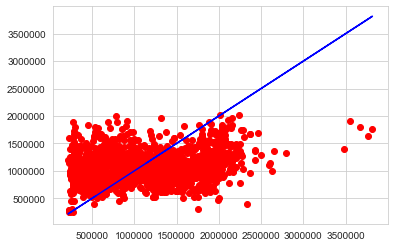

In [37]:
#Instantiate
knn = KNeighborsRegressor()
#Fit
knn.fit(XTrain, YTrain)
#Predict
YHatTest=knn.predict(XTest)

#Plotting 
plt.plot(YTest, YHatTest,'ro')
plt.plot(YTest, YTest,'b-')
plt.show()

In [38]:
# calculate the accuray of the model by sum of Square and mean absolute prediction error
MAPE = np.mean(abs((YTest - YHatTest)/YTest))
MSSE = np.mean(np.square(YHatTest - YTest))
print(r2_score(YTest,YHatTest))
print(MAPE, MSSE)

0.004160742946214158
0.6585075525101509 318390366830.49176


Using scaled data:

0.9162375208129622
0.07496902413625751 26780593641.079945


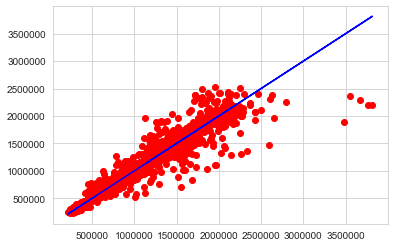

In [39]:
#Instantiate
knn = KNeighborsRegressor()
#Fit
knn.fit(X_transformed_train, YTrain)
#Predict
YHatTest=knn.predict(X_transformed_test)
# calculate the accuray of the model by sum of Square and mean absolute prediction error
MAPE = np.mean(abs((YTest - YHatTest)/YTest))
MSSE = np.mean(np.square(YHatTest - YTest))
print(r2_score(YTest,YHatTest))
print(MAPE, MSSE)
#Plotting 
plt.plot(YTest, YHatTest,'ro')
plt.plot(YTest, YTest,'b-')
plt.show()

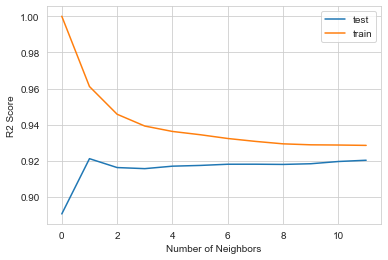

In [40]:
#Choosing best n_neighbors value
i=np.arange(1,25,2)
r2_test=[]
r2_train=[]

for x in i:
    KNN_model = KNeighborsRegressor(n_neighbors=x,n_jobs=-1)
    KNN_model.fit(X_transformed_train, YTrain)
    YHatTest = KNN_model.predict(X_transformed_test)
    r_test = r2_score(YTest,YHatTest)
    r2_test.append(r_test)
    prediction2 = KNN_model.predict(X_transformed_train)
    r_train = r2_score(YTrain,prediction2)
    r2_train.append(r_train)
#Plotting the accuracy versus number of neighbors value to find best value

plt.figure()
plt.plot(r2_test,label='test')
plt.plot(r2_train,label='train')
plt.xlabel('Number of Neighbors')
plt.ylabel('R2 Score')
plt.legend()
plt.show()

After 10,there is no improvement in test scores.

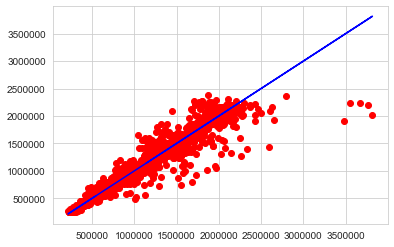

In [41]:
#KNN on ideal value
knn = KNeighborsRegressor(n_neighbors=10)
knn.fit(X_transformed_train, YTrain)
YHatTest=knn.predict(X_transformed_test)
plt.plot(YTest, YHatTest,'ro')
plt.plot(YTest, YTest,'b-')
plt.show()

In [42]:
MAPE = np.mean(abs((YTest - YHatTest)/YTest))
MSSE = np.mean(np.square(YHatTest - YTest))

print(r2_score(YTest,YHatTest))
print(MAPE, MSSE)

0.9173431540849879
0.07327603009202559 26427099861.268818


#### 3.Extra  Trees Regressor

0.07034253983472535 21876166247.920254
0.93157724789107


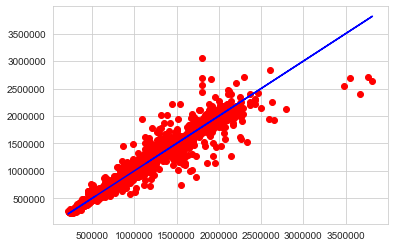

In [43]:
#Instantaite
clf = ExtraTreesRegressor()
#Fit
clf.fit(XTrain, YTrain)
#Predict
YHatTest=clf.predict(XTest)
# calculate the accuray of the model by sum of Square and mean absolute prediction error
MAPE = np.mean(abs((YTest - YHatTest)/YTest))
MSSE = np.mean(np.square(YHatTest - YTest))
print(MAPE, MSSE)
print(r2_score(YTest,YHatTest))
plt.plot(YTest, YHatTest,'ro')
plt.plot(YTest, YTest,'b-')
plt.show()

0.06840815238667336 21421398135.99923
0.9329996399791708


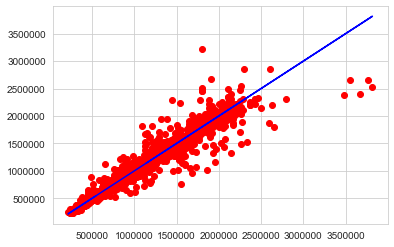

In [44]:
#Instantaite
clf = ExtraTreesRegressor()
#Fit
clf.fit(X_transformed_train, YTrain)
#Predict
YHatTest=clf.predict(X_transformed_test)
# calculate the accuray of the model by sum of Square and mean absolute prediction error
MAPE = np.mean(abs((YTest - YHatTest)/YTest))
MSSE = np.mean(np.square(YHatTest - YTest))
print(MAPE, MSSE)
print(r2_score(YTest,YHatTest))
plt.plot(YTest, YHatTest,'ro')
plt.plot(YTest, YTest,'b-')
plt.show()

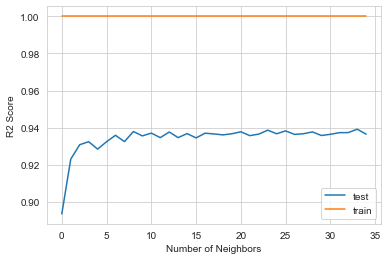

In [45]:
#Choosing best estimator value
i=np.arange(1,70,2)
r2_test=[]
r2_train=[]

for x in i:
    ET_model = ExtraTreesRegressor(n_estimators=x,n_jobs=-1)
    ET_model.fit(X_transformed_train, YTrain)
    YHatTest = ET_model.predict(X_transformed_test)
    r_test = r2_score(YTest,YHatTest)
    r2_test.append(r_test)
    prediction2 = ET_model.predict(X_transformed_train)
    r_train = r2_score(YTrain,prediction2)
    r2_train.append(r_train)
#Plotting the accuracy versus number of neighbors value to find best value

plt.figure()
plt.plot(r2_test,label='test')
plt.plot(r2_train,label='train')
plt.xlabel('Number of Neighbors')
plt.ylabel('R2 Score')
plt.legend()
plt.show()

The ideal n_estimators=10(There is no significant improvement in test scores after this)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


0.9347271805221486
0.06934092532415362 20869067764.107124


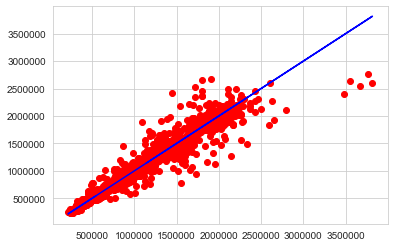

In [46]:
#Using ideal value
clf = ExtraTreesRegressor(n_estimators=10,max_features='auto', verbose=1, n_jobs=1)
clf.fit(X_transformed_train, YTrain)
YHatTest=clf.predict(X_transformed_test)
# calculate the accuray of the model by sum of Square and mean absolute prediction error
MAPE = np.mean(abs((YTest - YHatTest)/YTest))
MSSE = np.mean(np.square(YHatTest - YTest))
print(r2_score(YTest,YHatTest))
print(MAPE, MSSE)
plt.plot(YTest, YHatTest,'ro')
plt.plot(YTest, YTest,'b-')
plt.show()

#### 4.Random Forest Regressor

0.9270933468950018
0.06991555159865692 23309761954.112305


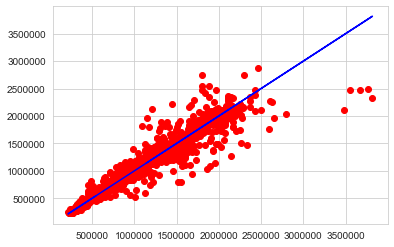

In [47]:
#Instantiate 
clf = RandomForestRegressor()
#Fit 
clf.fit(X_transformed_train, YTrain)
#Predict
YHatTest=clf.predict(X_transformed_test)
# calculate the accuray of the model by sum of Square and mean absolute prediction error
MAPE = np.mean(abs((YTest - YHatTest)/YTest))
MSSE = np.mean(np.square(YHatTest - YTest))
print(r2_score(YTest,YHatTest))
print(MAPE, MSSE)
plt.plot(YTest, YHatTest,'ro')
plt.plot(YTest, YTest,'b-')
plt.show()

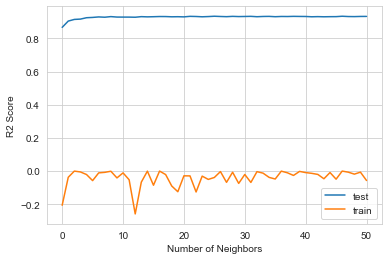

In [48]:
#Find ideal value
i=np.arange(1,102,2)
r2_test=[]
r2_train=[]

for x in i:
    RF_model = RandomForestRegressor(n_estimators=x,n_jobs=-1)
    RF_model.fit(X_transformed_train, YTrain)
    YHatTest = RF_model.predict(X_transformed_test)
    r_test = r2_score(YTest,YHatTest)
    r2_test.append(r_test)
    prediction2 = RF_model.predict(XTrain)
    r_train = r2_score(YTrain,prediction2)
    r2_train.append(r_train)
#Plotting the accuracy versus number of neighbors value to find best value

plt.figure()
plt.plot(r2_test,label='test')
plt.plot(r2_train,label='train')
plt.xlabel('Number of Neighbors')
plt.ylabel('R2 Score')
plt.legend()
plt.show()

Using ideal value=50 after which there is no significant improvement in test scores.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


0.9416601176870485
0.0704670078713485 18652464641.153557


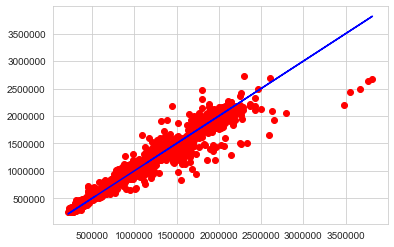

In [49]:
#Running model for ideal value
clf = RandomForestRegressor(n_estimators=50,max_features='log2', verbose=1)
clf.fit(X_transformed_train, YTrain)
YHatTest=clf.predict(X_transformed_test)
# calculate the accuray of the model by sum of Square and mean absolute prediction error
MAPE = np.mean(abs((YTest - YHatTest)/YTest))
MSSE = np.mean(np.square(YHatTest - YTest))
print(r2_score(YTest,YHatTest))
print(MAPE, MSSE)
plt.plot(YTest, YHatTest,'ro')
plt.plot(YTest, YTest,'b-')
plt.show()

#### 5.SVM

-0.03459785662169024
0.6100983494917479 330782291176.5659


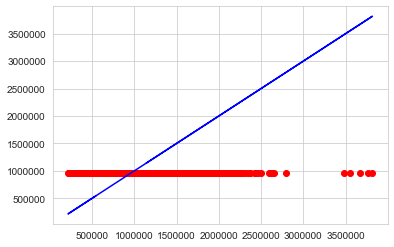

In [50]:
#Instantiate
clf = SVR(kernel='rbf', gamma='auto')
#Fit
clf.fit(X_transformed_train, YTrain)
#Predict
YHatTest=clf.predict(X_transformed_test)
# calculate the accuray of the model by sum of Square and mean absolute prediction error
MAPE = np.mean(abs((YTest - YHatTest)/YTest))
MSSE = np.mean(np.square(YHatTest - YTest))
print(r2_score(YTest,YHatTest))
print(MAPE, MSSE)

plt.plot(YTest, YHatTest,'ro')
plt.plot(YTest, YTest,'b-')
plt.show()

#### 6.MLP Regressor

In [51]:
#Instantiate
clf = MLPRegressor(hidden_layer_sizes=(10,),  activation='relu', verbose=3)
#fit
clf.fit(XTrain, YTrain)
#predict
YHatTest=clf.predict(XTest)



Iteration 1, loss = 701017048801.70947266
Iteration 2, loss = 701003338069.93420410
Iteration 3, loss = 700990119835.06945801
Iteration 4, loss = 700976867414.22497559
Iteration 5, loss = 700962658101.59875488
Iteration 6, loss = 700947198299.93994141
Iteration 7, loss = 700930378756.58081055
Iteration 8, loss = 700912289043.82336426
Iteration 9, loss = 700892701752.94604492
Iteration 10, loss = 700871726075.51159668
Iteration 11, loss = 700849313310.16625977
Iteration 12, loss = 700825345781.76538086
Iteration 13, loss = 700799964790.53088379
Iteration 14, loss = 700773054262.44519043
Iteration 15, loss = 700744434904.80883789
Iteration 16, loss = 700714475475.10754395
Iteration 17, loss = 700682758766.51708984
Iteration 18, loss = 700649686238.15637207
Iteration 19, loss = 700614906928.57019043
Iteration 20, loss = 700578576157.72619629
Iteration 21, loss = 700540761181.86669922
Iteration 22, loss = 700501356722.61999512
Iteration 23, loss = 700460286918.02990723
Iteration 24, loss =

Iteration 192, loss = 666371389116.98779297
Iteration 193, loss = 666055299020.83239746
Iteration 194, loss = 665739127649.84533691
Iteration 195, loss = 665421969867.57214355
Iteration 196, loss = 665102893141.63598633
Iteration 197, loss = 664784270163.30651855
Iteration 198, loss = 664462791422.83520508
Iteration 199, loss = 664140614406.34863281
Iteration 200, loss = 663818630688.27185059


C:\Users\b16z\Anaconda3\envs\deeplearning\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [52]:
# calculate the accuray of the model by sum of Square and mean absolute prediction error
MAPE = np.mean(abs((YTest - YHatTest)/YTest))
MSSE = np.mean(np.square(YHatTest - YTest))
print(r2_score(YTest,YHatTest))
print(MAPE, MSSE)

-3.2783308053143854
0.9507651941089227 1367870672779.3403


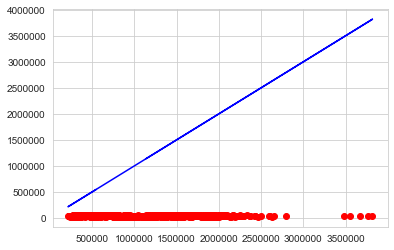

In [53]:
plt.plot(YTest, YHatTest,'ro')
plt.plot(YTest, YTest,'b-')
plt.show()

In [54]:
#Instantiate
clf = MLPRegressor(hidden_layer_sizes=(10,),  activation='relu', verbose=3)
#fit
clf.fit(X_transformed_train, YTrain)
#predict
YHatTest=clf.predict(X_transformed_test)


Iteration 1, loss = 701063199407.46948242
Iteration 2, loss = 701062788949.30065918
Iteration 3, loss = 701062358288.14587402
Iteration 4, loss = 701061892103.36254883
Iteration 5, loss = 701061377250.09020996
Iteration 6, loss = 701060810905.27819824
Iteration 7, loss = 701060184740.07092285
Iteration 8, loss = 701059499226.85815430
Iteration 9, loss = 701058743282.19311523
Iteration 10, loss = 701057920827.87524414
Iteration 11, loss = 701057019257.31896973
Iteration 12, loss = 701056047755.29821777
Iteration 13, loss = 701055001750.67089844
Iteration 14, loss = 701053874899.77563477
Iteration 15, loss = 701052657784.20056152
Iteration 16, loss = 701051347170.07202148
Iteration 17, loss = 701049937954.12170410
Iteration 18, loss = 701048429180.68603516
Iteration 19, loss = 701046823812.51306152
Iteration 20, loss = 701045127662.25598145
Iteration 21, loss = 701043331763.16528320
Iteration 22, loss = 701041437421.43261719
Iteration 23, loss = 701039464535.24450684
Iteration 24, loss =

Iteration 196, loss = 699766578124.82482910
Iteration 197, loss = 699755082344.48974609
Iteration 198, loss = 699743553566.24707031
Iteration 199, loss = 699731948001.92053223
Iteration 200, loss = 699720252615.00842285


C:\Users\b16z\Anaconda3\envs\deeplearning\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [55]:
# calculate the accuray of the model by sum of Square and mean absolute prediction error
MAPE = np.mean(abs((YTest - YHatTest)/YTest))
MSSE = np.mean(np.square(YHatTest - YTest))
print(r2_score(YTest,YHatTest))
print(MAPE, MSSE)


-3.5066572299096244
0.9990612219801895 1440871343890.7085


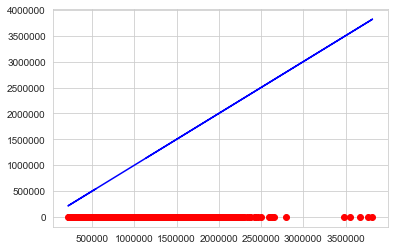

In [56]:
plt.plot(YTest, YHatTest,'ro')
plt.plot(YTest, YTest,'b-')
plt.show()

#### 7.Gradient Boosting Regressor

In [57]:
#Instantiate
clf = GradientBoostingRegressor(loss="huber")
#Fit
clf.fit(X_transformed_train, YTrain)
#Predict
YHatTest=clf.predict(X_transformed_test)


In [58]:
# calculate the accuray of the model by sum of Square and mean absolute prediction error
MAPE = np.mean(abs((YTest - YHatTest)/YTest))
MSSE = np.mean(np.square(YHatTest - YTest))
print(r2_score(YTest,YHatTest))
print(MAPE, MSSE)


0.8005028244803417
0.2347457327380229 63783365081.70049


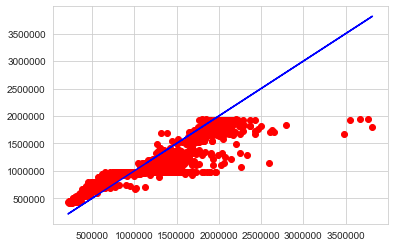

In [59]:
plt.plot(YTest, YHatTest,'ro')
plt.plot(YTest, YTest,'b-')
plt.show()

#### 8.Elastic Net 

In [60]:
clf = linear_model.ElasticNet(alpha=1.0, l1_ratio=0.5, fit_intercept=True)
#Fit
clf.fit(X_transformed_train, YTrain)
#Predict
YHatTest=clf.predict(X_transformed_test)

In [61]:
# calculate the accuray of the model by sum of Square and mean absolute prediction error
MAPE = np.mean(abs((YTest - YHatTest)/YTest))
MSSE = np.mean(np.square(YHatTest - YTest))
print(r2_score(YTest,YHatTest))
print(MAPE, MSSE)

0.803675512917605
0.24853568721449218 62768991096.91937


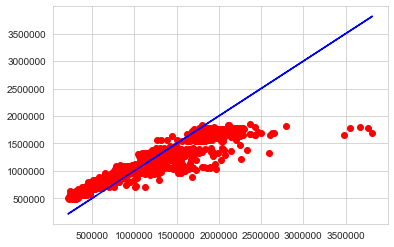

In [62]:
plt.plot(YTest, YHatTest,'ro')
plt.plot(YTest, YTest,'b-')
plt.show()

#### 8. XG Boost 

In [63]:
#Instantiate
clf = xgb.XGBRegressor()
#Fit
clf.fit(X_transformed_train, YTrain)
#Predict
YHatTest=clf.predict(X_transformed_test)

[13:34:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [64]:
# calculate the accuray of the model by sum of Square and mean absolute prediction error
MAPE = np.mean(abs((YTest - YHatTest)/YTest))
MSSE = np.mean(np.square(YHatTest - YTest))
print(r2_score(YTest,YHatTest))
print(MAPE, MSSE)

0.8071904926981709
0.2486015240557512 61645179504.02523


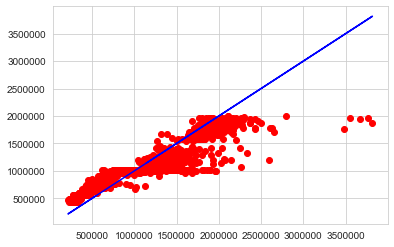

In [65]:
plt.plot(YTest, YHatTest,'ro')
plt.plot(YTest, YTest,'b-')
plt.show()

From these models,the models with most accurate models are :
* Random Forest Regressor
* Extra Trees Regressor 
* Lasso Regression

Here these models are predicting the sales based on input variables provided.But time factor is not considered.